<a href="https://colab.research.google.com/github/afuuuu/pytorch/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import pandas as pd
import numpy as np
import os
import csv

from sklearn.preprocessing import LabelEncoder


In [2]:
if torch.cuda.is_available():
    
    device = torch.device('cuda:0')
    print('GPU is avalible')
    print('Training on',torch.cuda.get_device_name())
else:
    device = torch.device('cpu')
    print('GPU is not avalible')
    print('Train on CPU')

GPU is avalible
Training on Tesla T4


## 資料前處理

In [3]:
path = 'Train/'
file_name = os.listdir(path)

RNA_name_multi = []
RNA_seq = []

N = 750  #for one-hot
text = ['B','D','E','F','H','I','J','K','L','M','O','P','Q','R','S','U','V','W','X','Y','Z'] #for change alph
for name in file_name:
    with open(path + name) as r:
        raw_data = r.readlines()
        #print(raw_data[:5])
        for data in raw_data:
            remove_blank = data.strip()
            messy = remove_blank.split(' ')
            #print(messy)
            if len(messy) == 2:
                RNA_name_multi.append(messy[1])
            else:
                
                seq = ''.join(messy)
                if len(seq) > 750:
                    seq = seq[:750]
                seq += 'N' * (N - len(seq))
                copy_seq = seq
                for alph in text:
                    copy_seq = copy_seq.replace(alph,'N')
                RNA_seq.append(copy_seq)
                
RNA_name = list(set(RNA_name_multi))  
#print(len(RNA_name))
RNA_dict = {i:[] for i in RNA_name}            

In [4]:
RNA_df = pd.DataFrame(RNA_name_multi, columns = ['RNA_name'])
RNA_df.insert(loc=1, column='RNA_seq', value=RNA_seq)
RNA_df

,RNA_name,RNA_seq
0,5_8S_rRNA,AACTTTCAACAACGGATCTCTTGGCTCTCGCATCGATGAAGAACGC...
1,5_8S_rRNA,AACTCTTAGCGGTGGATATCTTGGTTCTCGCAACGATGAAGAACGC...
2,5_8S_rRNA,AACTTTCAGCGATCGATGTCTCGGCTCGAACAACGATGAAGGGCAC...
3,5_8S_rRNA,CACTATTAGCGGTGGATGTCTTGGCTCCCACAACGATGAAGGCCGC...
4,5_8S_rRNA,AACTTTCGACAACGGATACCTTGGTTCCCCGATCGATGAAGAACGC...
...,...,...
5683,tRNA,GGAGGTATGGCTCAACTGGTAGAGTGCCTGCCTAGTGAGCTCAATG...
5684,tRNA,AGCAACATGGCCAAGTGGATAGGGCACAGGGACTGGAAGTCAGAGG...
5685,tRNA,TGTTTATAATATGAGTTGGTAAAGAGTCTGCCTGCAATGCAGAAGA...
5686,tRNA,GAGGGTATAGCACAGCAGTGAGGCGCATGCTTAACGCGCAGGAGGT...


In [5]:
for i in range(len(RNA_df)):
    for name in RNA_dict.keys():
        if name == RNA_df.iloc[i, 0]:
            RNA_dict[name].append(RNA_df.iloc[i, 1])

In [6]:
for key, value in RNA_dict.items():
    print('key : {}, value_len : {} '.format(key,len(value)))
    print('')

key : IRES, value_len : 288 

key : leader, value_len : 450 

key : 5_8S_rRNA, value_len : 450 

key : riboswitch, value_len : 450 

key : 5S_rRNA, value_len : 450 

key : Intron_gpI, value_len : 450 

key : miRNA, value_len : 450 

key : tRNA, value_len : 450 

key : scaRNA, value_len : 450 

key : CD-box, value_len : 450 

key : HACA-box, value_len : 450 

key : ribozyme, value_len : 450 

key : Intron_gpII, value_len : 450 



## one hot encoding

In [7]:
labelencoder = LabelEncoder()
seq_separate = []
for seq in RNA_seq:
    seq_separate.append(list(seq))
    
one_hot_x = []
for seq in seq_separate:
    seq_to_number = labelencoder.fit_transform(seq)
    #print(seq_to_number)
    one_hot = np.eye(5)[seq_to_number]  #np.eye 分成五類
    one_hot_x.append(one_hot)
    

In [8]:
one_hot_x

[array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]]), array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]]), array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]]), array([[0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]]), array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]]), array([[1., 0., 0., 0., 0.],


i = 0
for seq in one_hot_x: 
    if len(seq) > 750:
        print(i)
        #print(seq)
    i += 1

RNA_seq[1783]
print(RNA_seq[1783])
print(len(RNA_seq[1783])) ##1000

RNA_seq[5297]
print(RNA_seq[5297])
print(len(RNA_seq[5297])) ##770

## target 轉成數字

In [9]:
number_y = labelencoder.fit_transform(RNA_name_multi)
len(number_y)

5688

In [10]:
number_y  ##非以頭當作起始轉換點，而是以先看過資料找到排序後再轉換

array([ 1,  1,  1, ..., 12, 12, 12])

## 拆成train and val

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
x = one_hot_x
y = number_y

In [13]:
x_train_0, x_val_0, y_train_0, y_val_0 = train_test_split(x,y,test_size=0.1, random_state=42)
print(len(x_train_0),len(y_train_0))
print(len(x_val_0),len(y_val_0))

5119 5119
569 569


In [14]:
x_train_0[5].shape

(750, 5)

## Data Loader

In [15]:
x_train = x_train_0
x_val = x_val_0
y_train = y_train_0
y_val = y_val_0

batch_size = 64

In [16]:
x_train[0]

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [17]:
print(y_train[0])

8


In [18]:
train_loader_x = torch.utils.data.DataLoader(dataset= x_train, 
                                           batch_size= batch_size
                                                )
train_loader_y = torch.utils.data.DataLoader(dataset= y_train, 
                                           batch_size= batch_size, 
                                           )
validation_loader_x = torch.utils.data.DataLoader(dataset = x_val,
                                                batch_size = batch_size,
                                                )
validation_loader_y = torch.utils.data.DataLoader(dataset = y_val,
                                                batch_size = batch_size,
                                                )

## NN

In [19]:
input_size = 750
output = 64
compress = 5
p = 0.2

  1.nn.BatchNorm1d(num_features)
            1.对小批量(mini-batch)的2d或3d输入进行批标准化(Batch Normalization)操作
            2.num_features：
                    来自期望输入的特征数，该期望输入的大小为'batch_size x num_features [x width]'
                    意思即输入大小的形状可以是'batch_size x num_features' 和 'batch_size x num_features x width' 都可以。
                    （输入输出相同）
                    输入Shape：（N, C）或者(N, C, L)
                    输出Shape：（N, C）或者（N，C，L）
 
              eps：为保证数值稳定性（分母不能趋近或取0）,给分母加上的值。默认为1e-5。
              momentum：动态均值和动态方差所使用的动量。默认为0.1。
              affine：一个布尔值，当设为true，给该层添加可学习的仿射变换参数。
            3.在每一个小批量（mini-batch）数据中，计算输入各个维度的均值和标准差。gamma与beta是可学习的大小为C的参数向量（C为输入大小）
              在训练时，该层计算每次输入的均值与方差，并进行移动平均。移动平均默认的动量值为0.1。
              在验证时，训练求得的均值/方差将用于标准化验证数据。
            4.例子
                    >>> # With Learnable Parameters
                    >>> m = nn.BatchNorm1d(100) #num_features指的是randn(20, 100)中（N, C）的第二维C
                    >>> # Without Learnable Parameters
                    >>> m = nn.BatchNorm1d(100, affine=False)
                    >>> input = autograd.Variable(torch.randn(20, 100)) #输入Shape：（N, C）
                    >>> output = m(input)  #输出Shape：（N, C）
                   
        2.nn.BatchNorm2d(num_features)
            1.对小批量(mini-batch)3d数据组成的4d输入进行批标准化(Batch Normalization)操作
            2.num_features：
                    来自期望输入的特征数，该期望输入的大小为'batch_size x num_features x height x width'
                    （输入输出相同）
                        输入Shape：（N, C，H, W)
                        输出Shape：（N, C, H, W）
              eps： 为保证数值稳定性（分母不能趋近或取0）,给分母加上的值。默认为1e-5。
              momentum： 动态均值和动态方差所使用的动量。默认为0.1。
              affine： 一个布尔值，当设为true，给该层添加可学习的仿射变换参数。
            3.在每一个小批量（mini-batch）数据中，计算输入各个维度的均值和标准差。gamma与beta是可学习的大小为C的参数向量（C为输入大小）
              在训练时，该层计算每次输入的均值与方差，并进行移动平均。移动平均默认的动量值为0.1。
              在验证时，训练求得的均值/方差将用于标准化验证数据。
            4.例子
                >>> # With Learnable Parameters
                >>> m = nn.BatchNorm2d(100) #num_features指的是randn(20, 100, 35, 45)中（N, C，H, W)的第二维C
                >>> # Without Learnable Parameters
                >>> m = nn.BatchNorm2d(100, affine=False)
                >>> input = autograd.Variable(torch.randn(20, 100, 35, 45))  #输入Shape：（N, C，H, W)
                >>> output = m(input)
 
        3.nn.BatchNorm3d(num_features)
            1.对小批量(mini-batch)4d数据组成的5d输入进行批标准化(Batch Normalization)操作
            2.num_features：
                    来自期望输入的特征数，该期望输入的大小为'batch_size x num_features depth x height x width'
                    （输入输出相同）
                     输入Shape：（N, C，D, H, W)
                     输出Shape：（N, C, D, H, W）
 
              eps： 为保证数值稳定性（分母不能趋近或取0）,给分母加上的值。默认为1e-5。
              momentum： 动态均值和动态方差所使用的动量。默认为0.1。
              affine： 一个布尔值，当设为true，给该层添加可学习的仿射变换参数。

            3.在每一个小批量（mini-batch）数据中，计算输入各个维度的均值和标准差。gamma与beta是可学习的大小为C的参数向量（C为输入大小）
              在训练时，该层计算每次输入的均值与方差，并进行移动平均。移动平均默认的动量值为0.1。
              在验证时，训练求得的均值/方差将用于标准化验证数据。
            4.例子
                >>> # With Learnable Parameters
                >>> m = nn.BatchNorm3d(100)  #num_features指的是randn(20, 100, 35, 45, 10)中（N, C, D, H, W）的第二维C
                >>> # Without Learnable Parameters
                >>> m = nn.BatchNorm3d(100, affine=False)  #num_features指的是randn(20, 100, 35, 45, 10)中（N, C, D, H, W）的第二维C
                >>> input = autograd.Variable(torch.randn(20, 100, 35, 45, 10)) #输入Shape：（N, C, D, H, W）
                >>> output = m(input)

class ConvNet(nn.Module):
    def __init__(self):
        # 該函數在創建一個ConvNet對象的時候，即調用如下語句：net=ConvNet()，就會被調用
        # 首先調用父類相應的構造函數
        super(ConvNet, self).__init__()
        
        
        # convolution block
                               
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=32, kernel_size=3,padding = 1) 
        self.bn1_cov = nn.BatchNorm1d(32)
                           
        self.pool = nn.MaxPool1d(2) 
                        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3,padding = 1) 
        self.bn2_cov = nn.BatchNorm1d(64)   
         
        #
        self.flatten = nn.Flatten()
        
        
        # Dense block 
        self.fc1 = nn.Linear(187*64,64)   ## 第二個是batch_size
        self.bn1_den = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2_den = nn.BatchNorm1d(32)       
        self.fc3 = nn.Linear(32, 13)
        

    def forward(self, x):
        
        
        x = self.conv1(x) #batch_size*750*5 → batch_size*750*32
        print('conv1')
        print(x.shape)
        print('-'*20)
        x = self.bn1_cov(x)
        
        x = F.dropout(x, p = 0.5, training=self.training)
        
        x = F.relu(x)
        
        x = self.pool(x) #batch_size*750*32 → batch_size*(750/2)*32  
        print('pool1')
        print(x.shape)
        print('-'*20)
        x = self.conv2(x) #batch_size*375*32  → batch_size*187*64 
        print('conv2')
        print(x.shape)
        print('-'*20)
        x = self.bn2_cov(x)
        
        x = F.dropout(x, p = 0.5, training=self.training)
        
        x = F.relu(x)
        
        x = self.pool(x) #batch_size*350*64   → batch_size*(350/2)*64 
        print('pool2')
        print(x.shape)
        print('-'*20)
        
        
        
        #Flatten
        x = self.flatten(x) # 175*64
        print('Flatten')
        print(x.shape)
        print('-'*20)
        
        #Dense block
        x = self.fc1(x)
        print('Dense1')
        print(x.shape)
        print('-'*20)
        x = self.bn1_den(x)
        
        x = F.dropout(x, p = 0.5, training=self.training)
        
        x = F.relu(x)
        
        
        x = self.fc2(x)
        print('Dense2')
        print(x.shape)
        print('-'*20)
        x = self.bn2_den(x)
        
        x = F.dropout(x, p = 0.5, training=self.training)
        
        x = F.relu(x)
        
        
        x = self.fc3(x)
        print('Dense3')
        print(x.shape)
        print('-'*20)
        x = F.softmax(x, dim = 0)

        return x

In [20]:
class ConvNet(nn.Module):
    def __init__(self):
        # 該函數在創建一個ConvNet對象的時候，即調用如下語句：net=ConvNet()，就會被調用
        # 首先調用父類相應的構造函數
        super(ConvNet, self).__init__()
        
        
        # convolution block
                               
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=32, kernel_size=3,padding = 1) 
        self.bn1_cov = nn.BatchNorm1d(32)
                           
        self.pool = nn.MaxPool1d(2) 
                        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3,padding = 1) 
        self.bn2_cov = nn.BatchNorm1d(64)   
         
        #
        self.flatten = nn.Flatten()
        
        
        # Dense block 
        self.fc1 = nn.Linear(187*64,64)   ## 第二個是batch_size
        self.bn1_den = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2_den = nn.BatchNorm1d(32)       
        self.fc3 = nn.Linear(32, 13)
        

    def forward(self, x):
        
        
        x = self.conv1(x) #batch_size*750*5 → batch_size*750*32
       # print('conv1')
       # print(x.shape)
       # print('-'*20)
        x = self.bn1_cov(x)
        
        x = F.dropout(x, p = p, training=self.training)
        
        x = F.relu(x)
        
        x = self.pool(x) #batch_size*750*32 → batch_size*(750/2)*32  
       # print('pool1')
       # print(x.shape)
       # print('-'*20)
        x = self.conv2(x) #batch_size*375*32  → batch_size*187*64 
       # print('conv2')
       # print(x.shape)
       # print('-'*20)
        x = self.bn2_cov(x)
        
        x = F.dropout(x, p = p, training=self.training)
        
        x = F.relu(x)
        
        x = self.pool(x) #batch_size*350*64   → batch_size*(350/2)*64 
       # print('pool2')
       # print(x.shape)
       # print('-'*20)
        
        
        
        #Flatten
        x = self.flatten(x) # 175*64
       # print('Flatten')
       # print(x.shape)
       # print('-'*20)
        
        #Dense block
        x = self.fc1(x)
       # print('Dense1')
       # print(x.shape)
       # print('-'*20)
        x = self.bn1_den(x)
        
        x = F.dropout(x, p = p, training=self.training)
        
        x = F.relu(x)
        
        
        x = self.fc2(x)
      #  print('Dense2')
      #  print(x.shape)
      #  print('-'*20)
        x = self.bn2_den(x)
        
        x = F.dropout(x, p = p, training=self.training)
        
        x = F.relu(x)
        
        
        x = self.fc3(x)
      #  print('Dense3')
      #  print(x.shape)
      #  print('-'*20)
        x = F.softmax(x, dim = 0)

        return x

### 超參數

In [21]:
lr = 0.01
epochs = 100

In [22]:
model = ConvNet()
# 損失函數為交叉熵
criterion = nn.CrossEntropyLoss()
# 優化算法為Adam，可以自動調節學習率
optimizer = torch.optim.Adam(model.parameters(), lr = lr)


def rightness(predictions, labels):
    pred = torch.max(predictions.data, 1)[1] 
    rights = pred.eq(labels.data.view_as(pred)).sum() 
    return rights, len(labels) 

In [23]:
import warnings
warnings.filterwarnings('ignore')
record = []
losses = []
records = []



for epoch in range(epochs):
    train_losses = []
    train_rights = []
    model.train()
    for batch_idx, train in enumerate(zip(train_loader_x, train_loader_y )):
        x, y = train

        x = torch.tensor(x, requires_grad = True, dtype = torch.float)   
        x = x.permute(0,2,1)
        y = torch.tensor(np.array([z for z in y ]), dtype = torch.long)


        predict = model(x)
        loss = criterion(predict, y)
        right = rightness(predict, y)
        train_rights.append(right)
        train_losses.append(loss.data.numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(np.mean(train_losses))

    model.eval()
    val_losses = []
    val_rights = []
    with torch.no_grad():
        for j, val in enumerate(zip(validation_loader_x , validation_loader_y)):
            x, y = val
            x = torch.tensor(x, requires_grad = True, dtype = torch.float)
            x = x.permute(0,2,1)
            y = torch.tensor(np.array([z for z in y ]), dtype = torch.long)
            predict = model(x)
            loss = criterion(predict, y)
            right = rightness(predict, y)
            val_rights.append(right)
            val_losses.append(loss.data.numpy())

        train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
        val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
        print(val_r)


        print('訓練周期: {} Total Loss: {:.2f}\ttraining Loss: {:.2f}\tval Loss: {:.2f}\t訓練正確率: {:.2f}%\t校驗正確率: {:.2f}%'.format(
            epoch,
            np.mean(losses),
            np.mean(train_losses),
            np.mean(val_losses),
            100. * train_r[0].numpy() / train_r[1], 
            100. * val_r[0].numpy() / val_r[1]))
        t_r = 100. * (train_r[0] / train_r[1])
        v_r = 100. * (val_r[0] / val_r[1])
        record.append((100 - 100. * train_r[0] / train_r[1], 100 - 100. * val_r[0] / val_r[1]))
        records.append([np.mean(train_losses), np.mean(val_losses), t_r, v_r, np.mean(losses)])

(tensor(268), 569)
訓練周期: 0 Total Loss: 2.52	training Loss: 2.49	val Loss: 2.46	訓練正確率: 35.61%	校驗正確率: 47.10%
(tensor(303), 569)
訓練周期: 1 Total Loss: 2.49	training Loss: 2.44	val Loss: 2.43	訓練正確率: 45.56%	校驗正確率: 53.25%
(tensor(300), 569)
訓練周期: 2 Total Loss: 2.47	training Loss: 2.43	val Loss: 2.43	訓練正確率: 49.13%	校驗正確率: 52.72%
(tensor(311), 569)
訓練周期: 3 Total Loss: 2.46	training Loss: 2.42	val Loss: 2.41	訓練正確率: 50.40%	校驗正確率: 54.66%
(tensor(323), 569)
訓練周期: 4 Total Loss: 2.45	training Loss: 2.41	val Loss: 2.41	訓練正確率: 53.82%	校驗正確率: 56.77%
(tensor(321), 569)
訓練周期: 5 Total Loss: 2.44	training Loss: 2.41	val Loss: 2.42	訓練正確率: 53.70%	校驗正確率: 56.41%
(tensor(312), 569)
訓練周期: 6 Total Loss: 2.44	training Loss: 2.40	val Loss: 2.42	訓練正確率: 54.89%	校驗正確率: 54.83%
(tensor(311), 569)
訓練周期: 7 Total Loss: 2.43	training Loss: 2.40	val Loss: 2.42	訓練正確率: 55.46%	校驗正確率: 54.66%
(tensor(324), 569)
訓練周期: 8 Total Loss: 2.43	training Loss: 2.40	val Loss: 2.41	訓練正確率: 55.83%	校驗正確率: 56.94%
(tensor(311), 569)
訓練周期: 9 Total Loss

import warnings
warnings.filterwarnings('ignore')
record = []
losses = []
records = []



for epoch in range(epochs):
    train_losses = []
    train_rights = []
    model.train()
    for batch_idx, train in enumerate(zip(train_loader_x, train_loader_y )):
        x, y = train

        x = torch.tensor(x, requires_grad = True, dtype = torch.float)   
        x = x.permute(0,2,1)
        y = torch.tensor(np.array([z for z in y ]), dtype = torch.long)


        predict = model(x)
        loss = criterion(predict, y)
        right = rightness(predict, y)
        train_rights.append(right)
        train_losses.append(loss.data.numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if batch_idx % 10 == 0:
            losses.append(np.mean(train_losses))
            model.eval()
            val_losses = []
            val_rights = []
            with torch.no_grad():
                for j, val in enumerate(zip(validation_loader_x , validation_loader_y)):
                    x, y = val
                    x = torch.tensor(x, requires_grad = True, dtype = torch.float)
                    x = x.permute(0,2,1)
                    y = torch.tensor(np.array([z for z in y ]), dtype = torch.long)
                    predict = model(x)
                    loss = criterion(predict, y)
                    right = rightness(predict, y)
                    val_rights.append(right)
                    val_losses.append(loss.data.numpy())

                train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
                val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
                print(val_r)

                print('訓練周期: {} [{}/{} ({:.0f}%)]\tTotal Loss: {:.2f}\ttraining Loss: {:.2f}\tval Loss: {:.2f}\t訓練正確率: {:.2f}%\t校驗正確率: {:.2f}%'.format(
                    epoch, batch_idx * batch_size, len(x_train),
                    100. * batch_idx / len(train_loader_x), 
                    np.mean(losses),
                    np.mean(train_losses),
                    np.mean(val_losses),
                    100. * train_r[0].numpy() / train_r[1], 
                    100. * val_r[0].numpy() / val_r[1]), file=open('results1.txt', 'a'))
                print('訓練周期: {} [{}/{} ({:.0f}%)]\tTotal Loss: {:.2f}\ttraining Loss: {:.2f}\tval Loss: {:.2f}\t訓練正確率: {:.2f}%\t校驗正確率: {:.2f}%'.format(
                    epoch, batch_idx * batch_size, len(x_train),
                    100. * batch_idx / len(train_loader_x), 
                    np.mean(losses),
                    np.mean(train_losses),
                    np.mean(val_losses),
                    100. * train_r[0].numpy() / train_r[1], 
                    100. * val_r[0].numpy() / val_r[1]))
                record.append((100 - 100. * train_r[0] / train_r[1], 100 - 100. * val_r[0] / val_r[1]))
                records.append([np.mean(train_losses), np.mean(val_losses), train_r, val_r, losses])

Text(0, 0.5, 'Error rate')

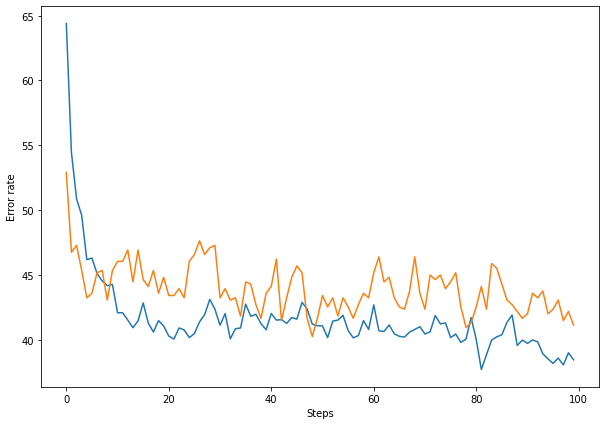

In [24]:
plt.figure(figsize = (10, 7))
plt.plot(record) 
plt.xlabel('Steps')
plt.ylabel('Error rate')

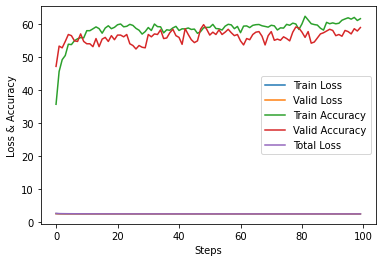

In [25]:
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
d = [i[3] for i in records]
e = [i[4] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Train Accuracy')
plt.plot(d, label = 'Valid Accuracy')
plt.plot(e, label = 'Total Loss')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()

# 保存模型
torch.save(model,'bow.mdl')
model = torch.load('bow.mdl')